In [ ]:
# default_exp nnsig

### Neural network using numpy
#### works on cpu only if there's no pyopencl and else

In [ ]:
#export
import numpy as np

#### fetch dataset

In [ ]:
#export
def fetch(url):
    import requests, hashlib, os, tempfile
    fp = os.path.join(tempfile.gettempdir(), hashlib.md5(url.encode('utf-8')).hexdigest())

    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    
    else:
        dat = requests.get(url).content
        with open(fp + ".tmp", "wb") as f:
            f.write(dat)
        
        os.rename(fp+".tmp", fp)
    
    return dat

In [ ]:
#export
def mnist(url1="http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", url2="http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz", url3="http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", url4="http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"):
    # from geohot
    import gzip
    import numpy as np

    def parse(dat): return np.frombuffer(
        gzip.decompress(dat), dtype=np.uint8).copy()

    X_train = parse(fetch(url1))[0x10:].reshape((-1, 28, 28))
    Y_train = parse(fetch(url2))[8:]
    X_test = parse(fetch(url3))[0x10:].reshape((-1, 28, 28))
    Y_test = parse(fetch(url4))[8:]
    return X_train, Y_train, X_test, Y_test


#### import mnist dataset

In [ ]:
x_train,y_train,x_test,y_test = mnist()
x_train.shape

(60000, 28, 28)

#### utils function

In [ ]:
#export 
# inits
def kaiming_uniform(h,w):
    return np.random.uniform(-1.,1.,size=(h,w))/np.sqrt(2/(h*w))

def kaiming_normal(h,w):
    return 

#### build the layers

In [ ]:
# export
class Linear:
    def __init__(self,h,w,init_fn = kaiming_uniform):
        self.weight = init_fn(h,w)
        self.grad = np.zeros((h,w))
        self.fpass = None
    
    def forward(self,x):
        out = x @ self.weight
        self.fpass = x
        return out
    
    def backward(self,bpass):
        self.grad = (self.fpass.T) @ bpass
        bpass = bpass @ (self.weight.T)

In [ ]:
one = Linear(784,128)
one.weight[0,:5], one.weight.shape, one.forward(x_train[0:1].reshape(1,-1)).shape

(array([ 193.36769103,   -0.78981443,  -77.92671738, -137.43862884,
          -6.53572108]),
 (784, 128),
 (1, 128))

In [ ]:
one.fpass.shape, one.grad.shape

((1, 128), (784, 128))

#### Loss functions

In [ ]:
# export 
def MSELoss(yhat,y):
    val = np.square(yhat - y).mean(axis=0)
    grad = 2 * (yhat - y) / len(yhat)
    return val, grad

def mse(yhat, y, num_class=10, supervised=True):
    """read num_class when supervised"""
    if supervised:
        label = np.zeros((len(y), num_class), dtype=np.float32)
        label[range(label.shape[0]), y] = 1
        y = label
    loss = np.square(np.subtract(yhat, y))  # vector form
    diff = 2*np.subtract(yhat, y)/(y.shape[-1])
    return loss, diff

def CELoss(yhat,y):
    """ cross entropy loss"""
    return

In [ ]:
a = np.array([[1,2],[3,4]])
a.mean(axis=0), a.mean(axis=1), a.mean(axis=-1)

(array([2., 3.]), array([1.5, 3.5]), array([1.5, 3.5]))

### Optimizer 

In [ ]:
# export
def SGD(lr = 1e-3, model = None):
    for layer in model:
        layer.weight -= lr * layer.grad

def Adam():
    pass

### Build Sequential model class ?

In [ ]:
# export
class Sequential:
    # learn **kwargs
    def __init__(self,layers,lossfn,opt_fn):
        if not isinstance(layers,list):
            self.model = [layers]
        else:
            self.model = layers
        
        self.lossfn = lossfn
        self.opt_fn = opt_fn
    
    # check arguments when it comes to validation
    def forward(self,x):
        out = self.model[0].forward(x)
        for layer in self.model[1:]:
            out = layer.forward(out)
        return out

    def backward(self,grad):
        for layer in reversed(self.model):
            # check if grad = grad @ (weight.T) works
            layer.backward(grad)
            grad = grad @ (layer.weight.T)

    def fit(self,x,y,epoch=1,batch_size=64,x_test=None,y_test=None):
        # loop thru len//bs
        losses = []
        ln = len(x)
        for _ in range(epoch*ln//batch_size):
            idx = np.random.randint(0,ln,size=batch_size)
            x_ = x[idx].reshape((-1,28*28))
            y_ = y[idx].reshape((y[idx].shape[0],1))
            out = self.forward(x_)

            loss, grad = self.lossfn(out,y_)

            self.backward(grad)

            self.opt_fn(lr=1e-7, model=self.model)

            losses.append(loss.mean())
        
        return losses

    def fit_one_batch(self,x,y,epoch=1,batch_size=64,x_test=None,y_test=None):
        # loop thru len//bs
        losses = []
        ln = len(x)
        for _ in range(epoch):
            idx = np.random.randint(0,ln,size=batch_size)
            x_ = x[idx].reshape((-1,28*28))
            y_ = y[idx]#.reshape((y[idx].shape[0],1))
            out = self.forward(x_)
            #print(np.argmax(x_),y_)

            # gradient blows up
            loss, grad = self.lossfn(y_,out)

            self.backward(grad)

            self.opt_fn(lr=1e-8, model=self.model)

            losses.append(loss.mean())
        
        return losses        


In [ ]:
# train for a epoch here
model = Sequential([Linear(784,128),Linear(128,10)],mse,SGD)

losses = model.fit_one_batch(x_train,y_train,epoch=2)

IndexError: arrays used as indices must be of integer (or boolean) type

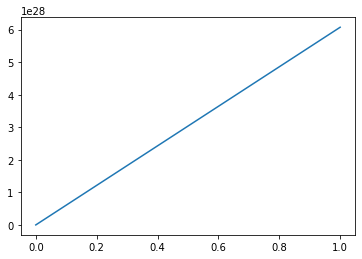

In [ ]:
from matplotlib import pyplot as plt
plt.plot(list(range(len(losses)))[:3],losses[:3])
plt.show()

### Experiment below

In [ ]:
model = [Linear(784,128), Linear(128,10)]

...


#### Rebuild everything from a lower level
#### e.g. a tensor for layers to inherit from that handles backprop

### Export

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_oval_clean.ipynb.
Converted 02_NN.ipynb.
Converted 03_NN_numpy.ipynb.
Converted index.ipynb.
